# Calculate Air Density for a time and place in the past

In this notebook, we compare a couple of models of air density. Then create an air density function that takes pressure and temperature, together with either dew point on relative humidity. Next we use a function to scrape the weather for a historical time and place. The we combine these to obtain the corresponding air density. 

# Calculate Air Density
Source : https://wahiduddin.net/calc/density_altitude.htm#b15 <br>
First try compare the two models to calculate saturation vapour pressure, Es, in millibars at temperature T degrees C. 

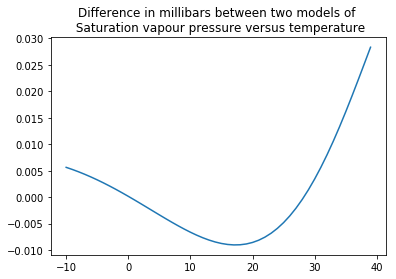

At temperature  15  Model 1 Es= 17.0435326061  Model 2 Es= 17.0522836608


In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

# Compare two formulae to calculate the saturation vapour pressure of water in air (mBar) at temperature where T  (degrees C)
T=np.arange(-10,40)
#Method 1
eso=6.1078
c0 = 0.99999683
c1 = -0.90826951*10**-2
c2 = 0.78736169*10**-4
c3 = -0.61117958*10**-6
c4 = 0.43884187*10**-8
c5 = -0.29883885*10**-10
c6 = 0.21874425*10**-12
c7 = -0.17892321*10**-14
c8 = 0.11112018*10**-16
c9 = -0.30994571*10**-19
Es1 = eso/(c0+T*(c1+T*(c2+T*(c3+T*(c4+T*(c5+T*(c6+T*(c7+T*(c8+T*c9)))))))))**8 

# Method2
c10 = 6.1078
c11 = 7.5
c12 = 237.3       
Es2 = c10 * 10 **(c11*T/(c12+T)) 

plt.plot(T,Es1-Es2)
plt.title('Difference in millibars between two models of \n Saturation vapour pressure versus temperature')
plt.show()

Temp = 15+10
print ('At temperature ',T[Temp],' Model 1 Es=',Es1[Temp],' Model 2 Es=',Es2[Temp])

We quickly conclude that for relevant temperature ranges the simpler model is just as good as the complex one. So we run with the simpler one. <br>

## First attempt to create a function
Note that at dew point the vapour pressure of water equals the saturation vapour pressure Es = Vp. This is where relative humidity, hum, is 100%, because relative humidity is defined as Pv / Es. This means it is straightforward for the function to use relative humidity if the dew point temperature is not avaiable, or, if neither is supplied, assume that the relative humidity is 80%, which is around average for the UK.

In [2]:

def rhoCalc1(Pressure=1020, Temp=15, DP=False, Humidity=False):
    """ Takes pressure P in millibars (so multiply by 100 to get Pascals)
    ambient temperature T and dew point DP in degrees C or and relative humidity where 80% entered as 80
    Returns air density in kg/m^3 """ 
    Rd = 287.05  #J/(kg*degK)
    Rv = 461.495 #J/(kg*degK)
    c10 = 6.1078
    c11 = 7.5
    c12 = 237.3 
    Es = c10 * 10 **(c11*Temp/(c12+Temp))   # Saturation Vapour Pressure
    if not(isinstance(DP,bool)):
        Pv = c10 * 10 **(c11*DP/(c12+DP)) # Vapour pressure at dew point
    elif not(isinstance(Humidity,bool)):
        if Humidity > 1: Humidity /= 100
        Pv = Humidity * Es      # relativeHumidity is defined as Pv / Es
    else:
        Pv = 0.8 * Es      # Average relative humidity in the UK is 80%
    
    airDensity =  Pressure*100/Rd/(Temp+273.15)*(1-Pv/Pressure*(1-Rd/Rv))
    return airDensity

print('With DP supplied ',rhoCalc1(Pressure=1013.25, Temp=15, DP=13), 'No DP supplied ',rhoCalc1(1013.25, 15), \
      'With hum supplied ',rhoCalc1(Pressure=1013.15, Temp=15, Humidity=95),)

With DP supplied  1.2181679079620102 No DP supplied  1.2187779632747076 With hum supplied  1.2174881322047284


In [3]:
print(rhoCalc1(1034,0,Humidity=0), rhoCalc1(1034,0,Humidity=50), rhoCalc1(1034,0,Humidity=100))

1.3187479049811526 1.3172756345770151 1.3158033641728772


# Final version of function with altitude adjustment
Final version of function adjusts the sea level pressure reported by weather agencies to local pressure at specified elevation. So, to be clear, we use sea level pressure, but local temperature, humidity and elevation. The sea level pressure is converted to local pressure based on the temperature difference between local elevation and that at sea level (ignoring variations in g for altitude).

In [ ]:
def rhoCalc(Pressure=1020, Temp=15, DP=False, Humidity=False, Elevation=0):
    """ Takes pressure P in millibars (so multiply by 100 to get Pascals)
    ambient temperature T and dew point DP in degrees C and/or relative humidity where 80% entered as 80
    and elevation  in m
    Returns air density in kg/m^3 """ 
    Rd = 287.05  #J/(kg*degK)
    Rv = 461.495 #J/(kg*degK)
    c10 = 6.1078
    c11 = 7.5
    c12 = 237.3
    g =  9.80665   # gravitational constant, m/sec^2
    M = 28.9644/1000    # molecular weight of dry air, kg/mol
    L =  6.5/1000  # temperature lapse rate, deg K/m
    R = 8.31432    # gas constant, J/ (mol*deg K) 
    Es = 100 * c10 * 10 **(c11*Temp/(c12+Temp))   # Saturation Vapour Pressure in kg/m^3
    if not(isinstance(DP,bool)):
        Pv = 100 * c10 * 10 **(c11*DP/(c12+DP)) # Vapour pressure at dew point in kg/m^3
    elif not(isinstance(Humidity,bool)):
        if Humidity > 1: Humidity /= 100
        Pv = Humidity * Es      # relativeHumidity is defined as Pv / Es
    else:
        Pv = 0.8 * Es      # Average relative humidity in the UK is 80%
    TempK = Temp + 273.15
    localP = Pressure * 100 * (TempK / (TempK + L * Elevation)) ** (g*M/(R*L)) # multiply by 100 to get kg/m^3 and adjust for elevation
    
    airDensity =  localP  / Rd / TempK * (1-Pv/localP*(1-Rd/Rv))
    return airDensity

In [4]:
print('With DP supplied ',rhoCalc(Pressure=1013.25, Temp=15, DP=13), 'No DP supplied ',rhoCalc(1013.25, 15), \
      'With hum supplied ',rhoCalc(Pressure=1013.25, Temp=15, Humidity=95), 'At 1000m', rhoCalc(Pressure=1013.25, Temp=15, Humidity=95, Elevation = 1000))

With DP supplied  1.2181679079620102 No DP supplied  1.2187779632747076 With hum supplied  1.2176090315154602 At 1000m 1.08208475667082


In [5]:
Temp,Pressure,Elevation = 15,1013.25,1000
g =  9.80665   # gravitational constant, m/sec^2
M = 28.9644/1000    # molecular weight of dry air, kg/mol
L =  6.5/1000  # temperature lapse rate, deg K/m
R = 8.31432    # gas constant, J/ mol*deg K 
TempK = Temp + 273.15
localP = Pressure * 100 * (TempK / (TempK + L * Elevation)) ** (g*M/(R*L)) # multiply by 100 to get kg/m^3 and adjust for elevation
print('Elevation adjusted pressure {:.2f} mBar'.format(localP/100))


Elevation adjusted pressure 901.15 mBar


# Also tried a few other online sources that didn't seem to work

In [6]:
import metoffer
api_key = 'd4339fa7-64f7-4139-a378-cd7546262a89'
M = metoffer.MetOffer(api_key)
x= metoffer.get_nearest_site( lon=-0.3375,lat=51.4033,sites=1)
print(x)
#x = M.nearest_loc_forecast(51.4033, -0.3375, metoffer.THREE_HOURLY)


ModuleNotFoundError: No module named 'metoffer'

In [7]:

import datapoint
api_key = 'd4339fa7-64f7-4139-a378-cd7546262a89'
conn = datapoint.connection(api_key=api_key)
site = conn.get_nearest_site(-0.3375, 51.4033)
print (site.name)

# Get a forecast for the nearest site
forecast = conn.get_forecast_for_site(site.id, "3hourly")

# Loop through days and print date
for day in forecast.days:
    print ("\n%s" % day.date)

    # Loop through time steps and print out info
    for timestep in day.timesteps:
        print (timestep.date)
        print (timestep.weather.text)
        print ("%s%s%s" % (timestep.temperature.value,
                          u'\xb0', #Unicode character for degree symbol
                          timestep.temperature.units))

ModuleNotFoundError: No module named 'datapoint'

In [8]:
site.id

NameError: name 'site' is not defined

Sample web address
http://datapoint.metoffice.gov.uk/public/data/val/wxfcs/all/xml/351747?res=3hourly&key=d4339fa7-64f7-4139-a378-cd7546262a89


In [9]:
# Import JSON version
import pandas as pd
xx=pd.read_json('http://datapoint.metoffice.gov.uk/public/data/val/wxfcs/all/json/351747?res=3hourly&key=d4339fa7-64f7-4139-a378-cd7546262a89')

In [10]:
rhoCalcE(Pressure=1013.25, Temp=13, Humidity=0, Elevation=0)

NameError: name 'rhoCalcE' is not defined

In [11]:
rhoCalcE(Pressure=1019.3, Temp=24, Humidity=0, Elevation=2000)

NameError: name 'rhoCalcE' is not defined

In [ ]:
x,y,z=False,0,.5
x==0.0

In [ ]:
print(rhoCalcE(1013,15,Humidity=0,Elevation=0), rhoCalcE(1013,15-10*6.5,Humidity=0,Elevation=10000), rhoCalcE(1013,15-2*6.5,Humidity=0,Elevation=2000))

In [12]:
print(rhoCalc(996,4,Humidity=100,Elevation=10))

1.2465437300140692
